In [1]:
# ! pip install pandas numpy matplotlib scikit-learn mlxtend tensorflow keras
# ! pip install --upgrade keras
# ! pip install np_utils
# ! pip install ipywidgets

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from keras import models
from keras.utils import to_categorical

from tensorflow import convert_to_tensor
from tensorflow.image import grayscale_to_rgb
from tensorflow.data import Dataset
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model

In [3]:
data = pd.read_csv('https://github.com/unclethien/Facial-Expression-Recognition/raw/main/Dataset/icml_face_data.csv')
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [4]:
data[' Usage'].value_counts()

 Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [5]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [6]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [7]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [8]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [9]:
# As the pretrained model expects rgb images, we convert our grayscale images with a single channel to pseudo-rgb images with 3 channels
train_images_rgb = grayscale_to_rgb(convert_to_tensor(train_images))
val_images_rgb = grayscale_to_rgb(convert_to_tensor(val_images))
test_images_rgb =  grayscale_to_rgb(convert_to_tensor(test_images))

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_rgb_datagen = ImageDataGenerator(
    rotation_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)

train_rgb_datagen.fit(train_images_rgb)

In [11]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

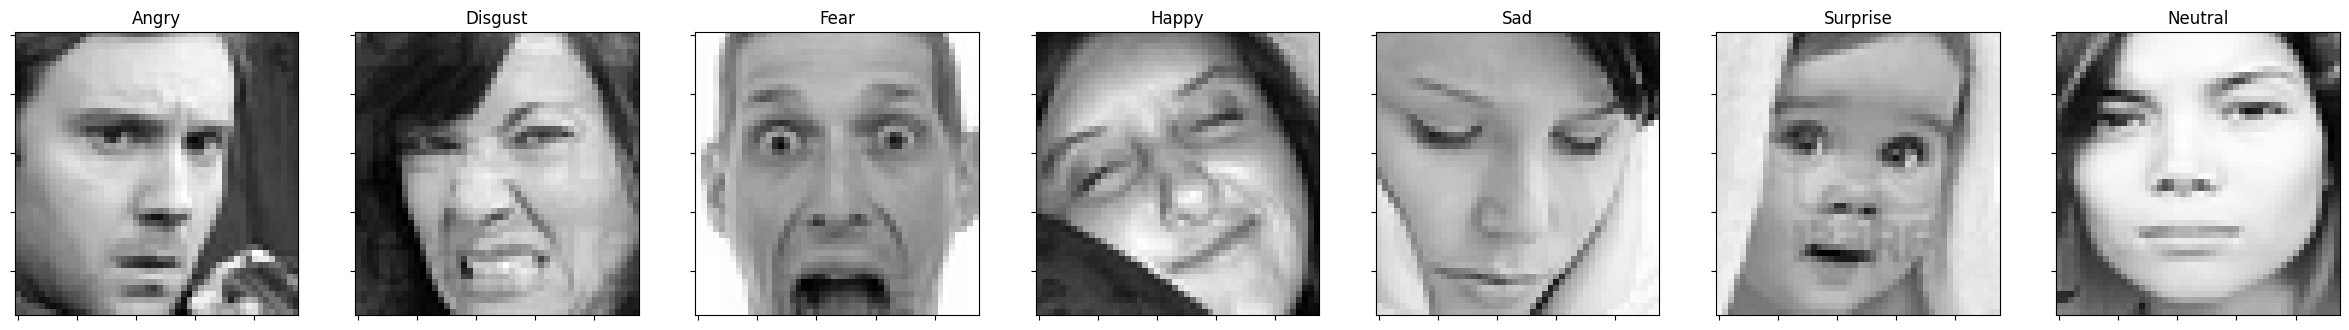

In [12]:
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

plot_all_emotions()

In [13]:
#Plot 5 examples of one emotion
def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

#### Angry

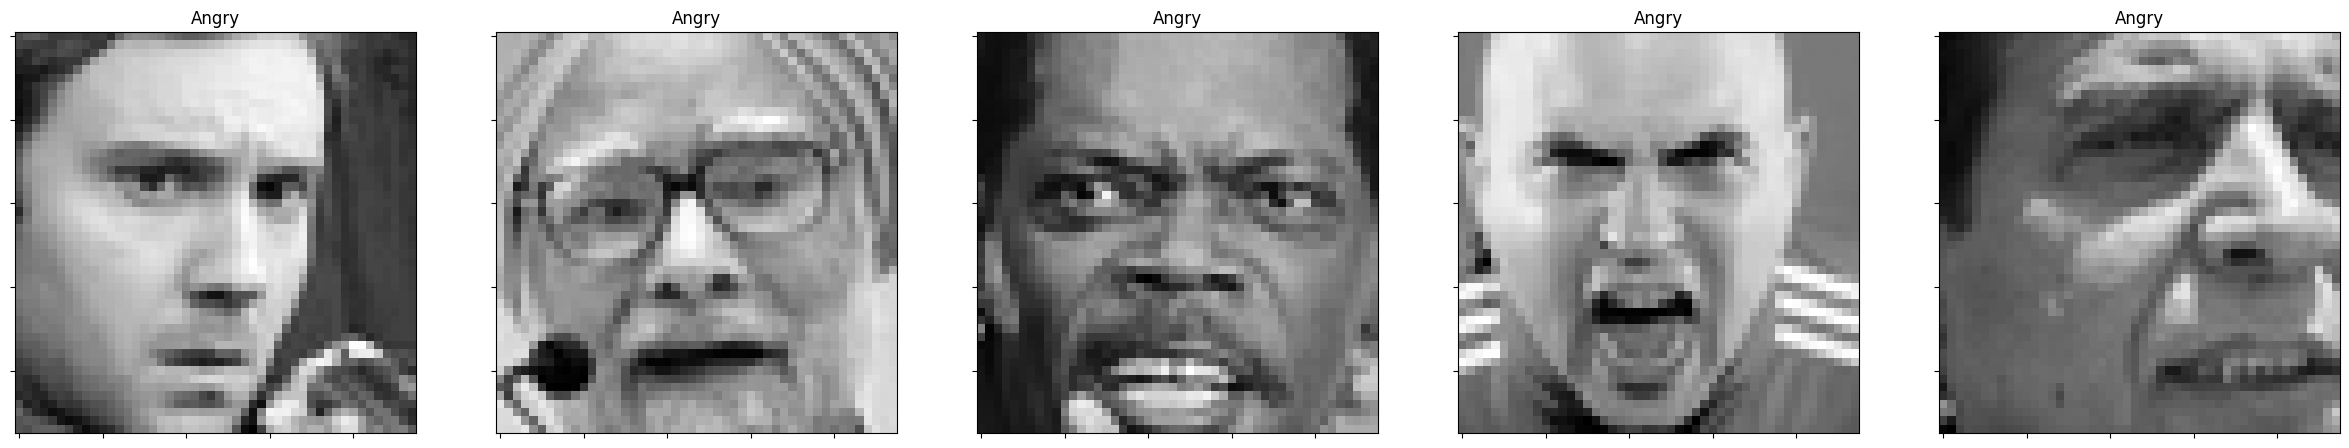

In [14]:
plot_examples(label=0)

#### Digust

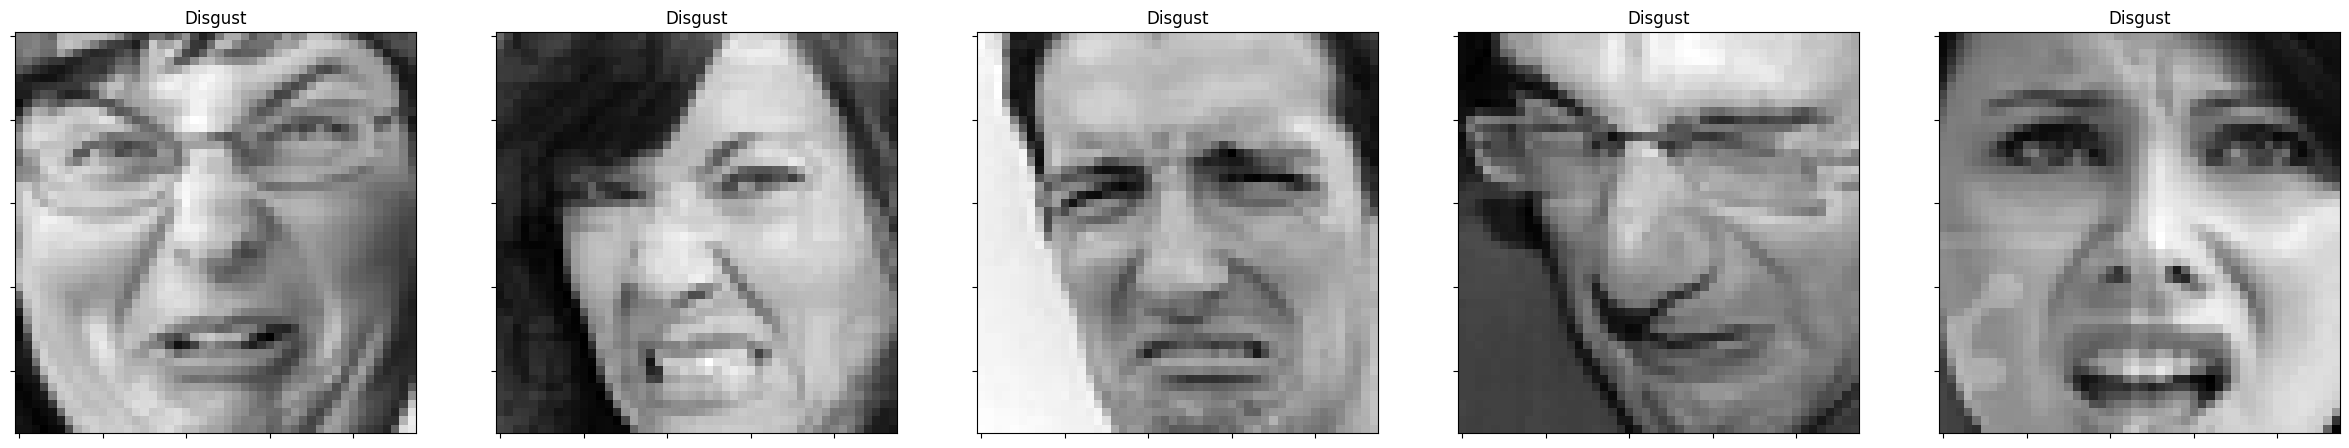

In [15]:
plot_examples(label=1)

#### Fear

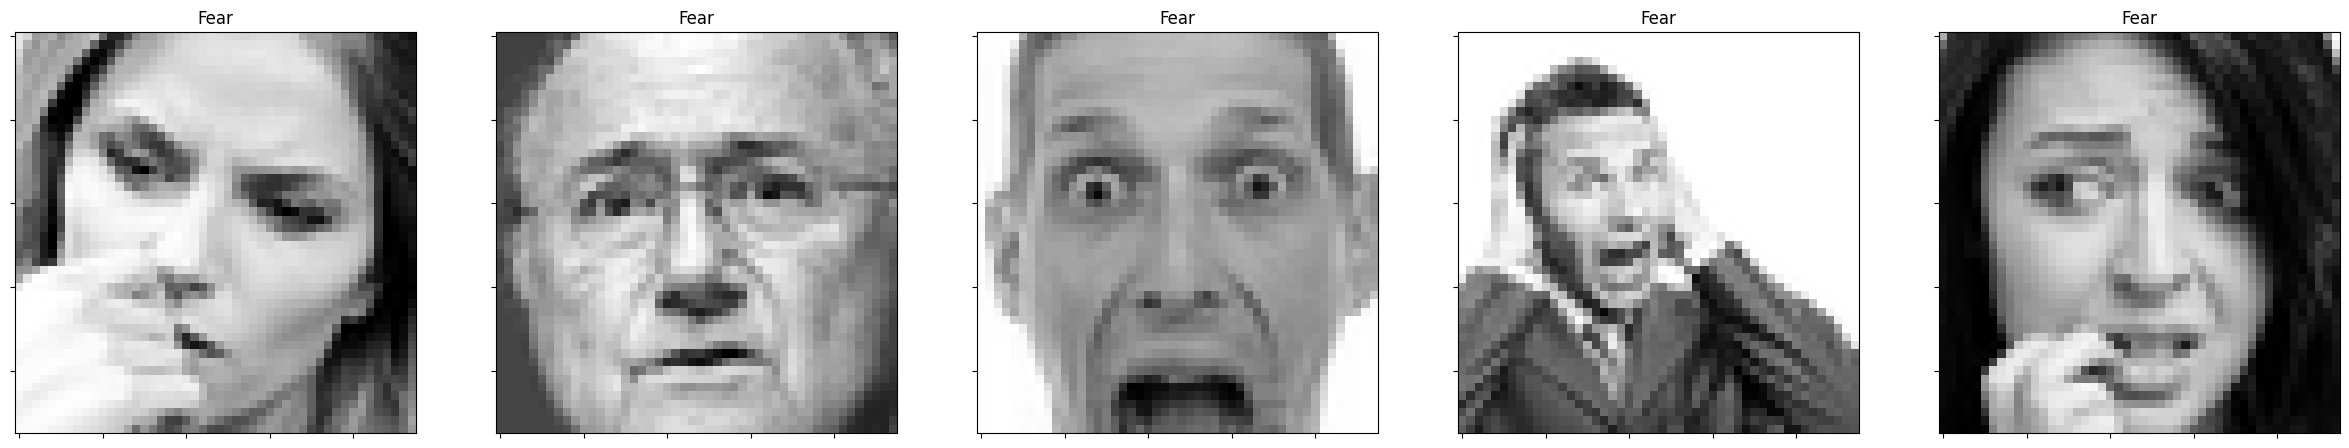

In [16]:
plot_examples(label=2)

#### Happy

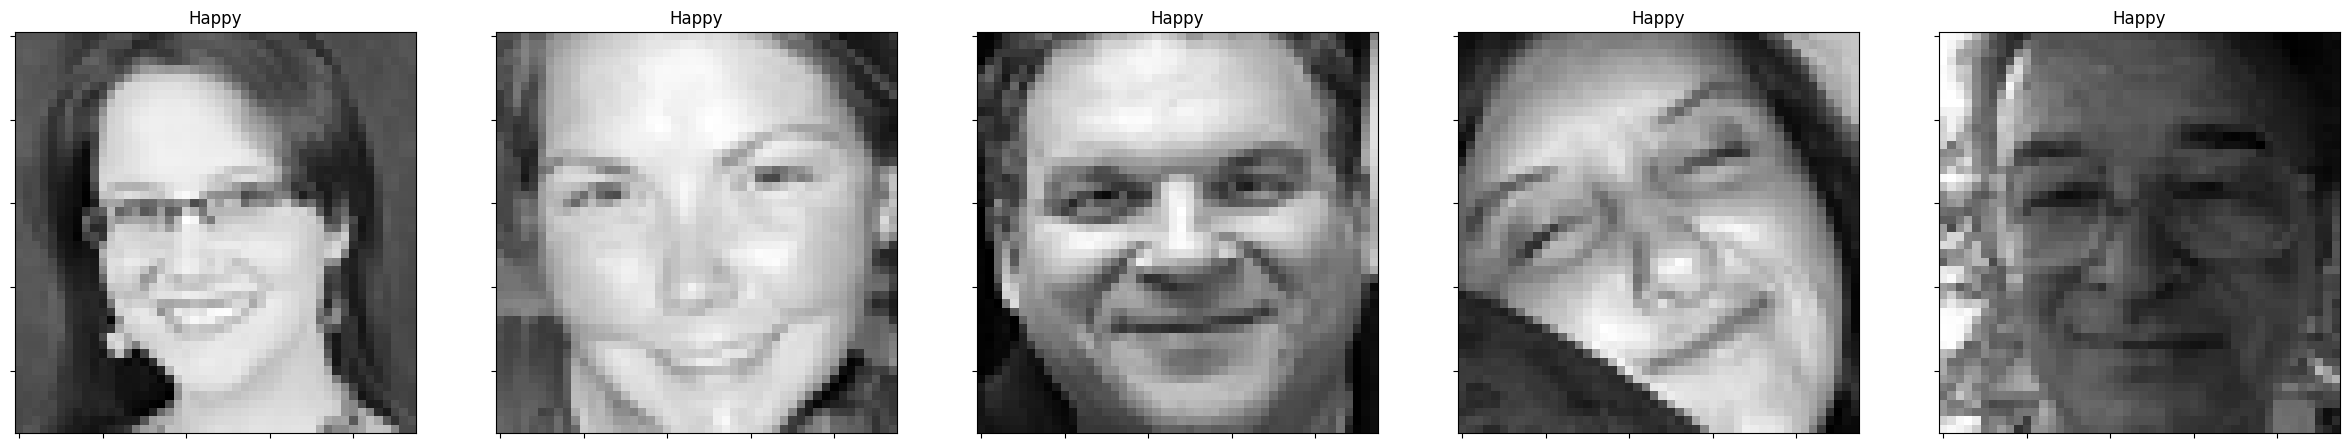

In [17]:
plot_examples(label=3)

#### Surprise

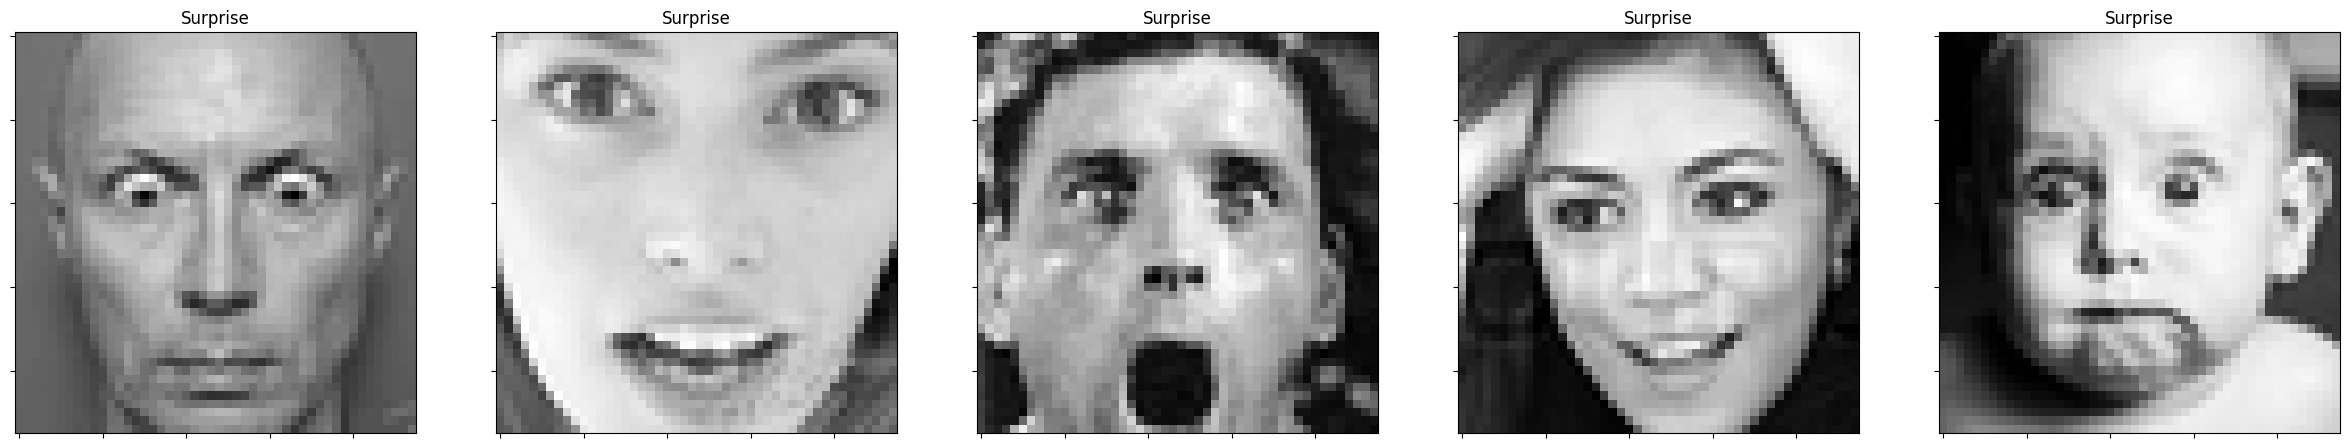

In [18]:
plot_examples(label=5)

#### Neutral

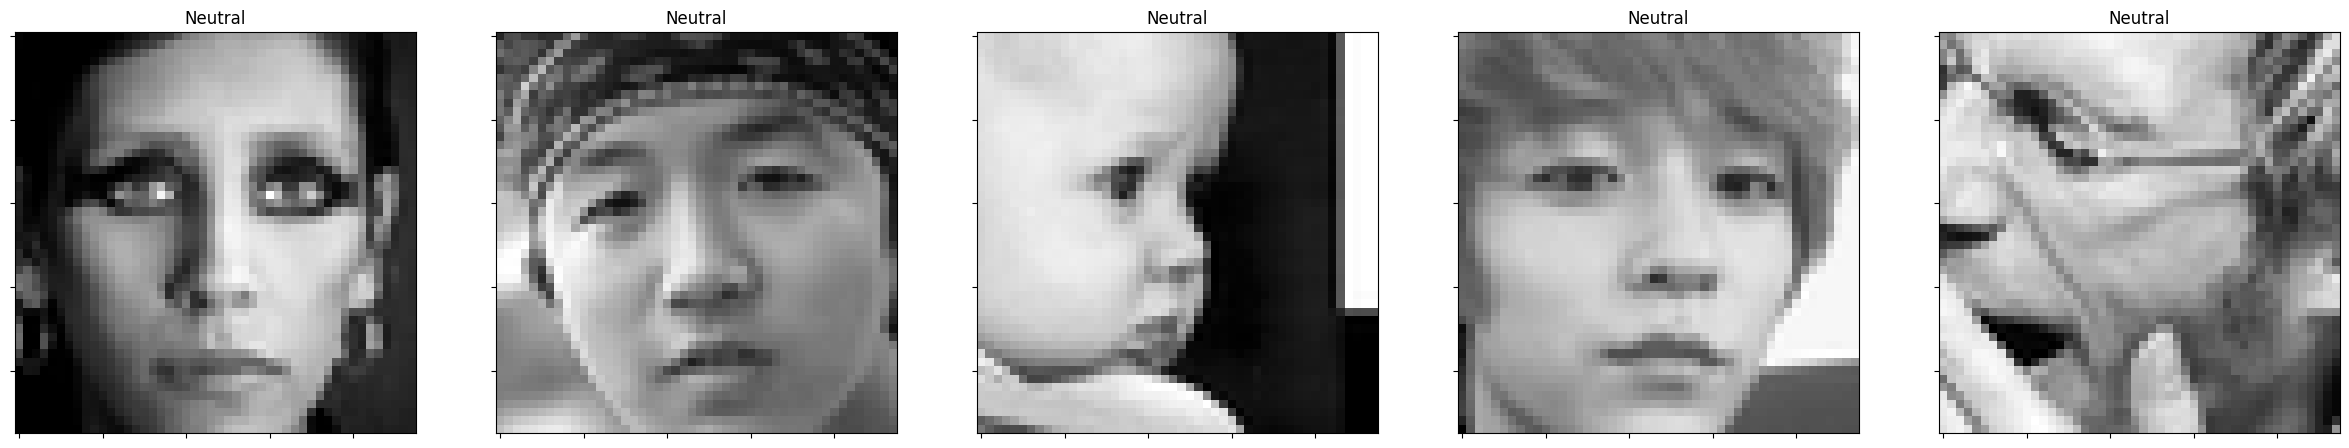

In [19]:
plot_examples(label=6)

In [20]:
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

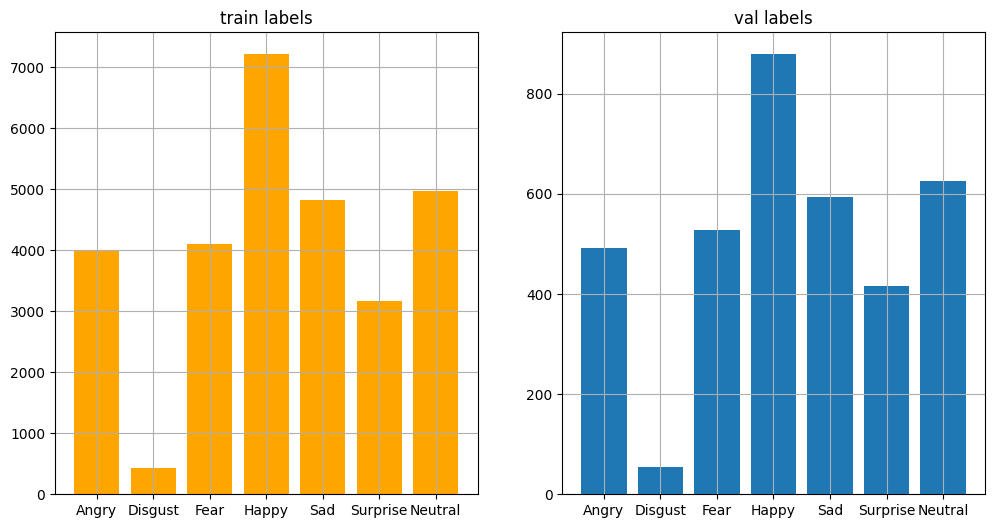

In [21]:
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

In [22]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))
class_weight



{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

In [23]:
#Define callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=20,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    filepath="best_model.h5",
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

model_checkpoint = ModelCheckpoint(filepath="best_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto') 
callbacks = [
    early_stopping,
    lr_scheduler,
    model_checkpoint
]

In [24]:
#General shape parameters
IMG_SIZE = 48
NUM_CLASSES = 7
BATCH_SIZE = 64

In [25]:
#A plotting function to visualize training progress
def render_history(history, suf=''):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.95,
                        top=0.9,
                        wspace=0.4)
    
    ax1.set_title("Losses")
    ax1.plot(history.history["loss"], label="loss")
    ax1.plot(history.history["val_loss"], label="val_loss")
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('value of the loss function')
    ax1.legend()

    ax2.set_title("Accuracies")
    ax2.plot(history.history["accuracy"], label="accuracy")
    ax2.plot(history.history["val_accuracy"], label="val_accuracy")
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('value of accuracy')
    ax2.legend()
    
    plt.show()
    suf = '' if suf == '' else '_'+suf
    fig.savefig('loss_and_acc'+suf +'.png')

In [26]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

#By specifying the include_top=False argument, we load a network that 
#doesn't include the  classification layers at the top, which is ideal for feature extraction.
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                     include_top=False,
                     weights='imagenet')

#plot_model(base_net, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='mobilenet_full.png')

In [27]:
base_model = Model(inputs = base_model.input,outputs = base_model.get_layer('block_12_project_BN').output, name = 'mobilenet_trunc')


In [28]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras import Input, Model

global_average_layer = GlobalAvgPool2D()
prediction_layer = Dense(NUM_CLASSES, activation="softmax", name="pred")
inputs_raw = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs_raw, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = Model(inputs=inputs_raw, outputs= outputs)


In [29]:
from keras.optimizers import Adam
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(lr=1e-3),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 mobilenet_trunc (Functiona  (None, 3, 3, 96)          558656    
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 96)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 pred (Dense)                (None, 7)                 679       
                                                                 
Total params: 559335 (2.13 MB)
Trainable params: 679 (2.65 KB)
Non-trainable params: 558656 (2.13 MB)
_________________________________________________________________


In [30]:
initial_epochs = 5
history = model.fit_generator(train_rgb_datagen.flow(train_images_rgb, 
                                                 train_labels, 
                                                 batch_size=BATCH_SIZE),
                              validation_data=(val_images_rgb, 
                                               val_labels),
                              class_weight = class_weight,
                              steps_per_epoch=len(train_images) / BATCH_SIZE,
                              #initial_epoch = history.epoch[-1],
                              #epochs = total_epochs,
                              epochs = initial_epochs,
                              callbacks=callbacks)

C:\Users\thien\AppData\Local\Temp\ipykernel_21880\3261094124.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_rgb_datagen.flow(train_images_rgb,


Epoch 1/5
449/448 [==============================] - ETA: 0s - loss: 0.3470 - accuracy: 0.2324
Epoch 1: val_accuracy improved from -inf to 0.28253, saving model to best_model.h5


c:\Users\thien\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


448/448 [==============================] - 30s 62ms/step - loss: 0.3470 - accuracy: 0.2324 - val_loss: 1.8869 - val_accuracy: 0.2825 - lr: 0.0010
Epoch 2/5
449/448 [==============================] - ETA: 0s - loss: 0.2760 - accuracy: 0.3055
Epoch 2: val_accuracy improved from 0.28253 to 0.31067, saving model to best_model.h5
448/448 [==============================] - 28s 62ms/step - loss: 0.2760 - accuracy: 0.3055 - val_loss: 1.8235 - val_accuracy: 0.3107 - lr: 0.0010
Epoch 3/5
449/448 [==============================] - ETA: 0s - loss: 0.2662 - accuracy: 0.3305
Epoch 3: val_accuracy improved from 0.31067 to 0.32070, saving model to best_model.h5
448/448 [==============================] - 28s 63ms/step - loss: 0.2662 - accuracy: 0.3305 - val_loss: 1.7510 - val_accuracy: 0.3207 - lr: 0.0010
Epoch 4/5
449/448 [==============================] - ETA: 0s - loss: 0.2613 - accuracy: 0.3407
Epoch 4: val_accuracy improved from 0.32070 to 0.33380, saving model to best_model.h5
448/448 [==========

In [31]:
iterative_finetuning = True 

In [32]:
if iterative_finetuning:
    ftsuf = 'ft_2'
else:
    ftsuf = 'ft_atonce'


In [33]:

print("Number of layers in the base model: ", len(base_model.layers))
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-37:]: #blocks 7-12
  layer.trainable = True
optims = {'adam': optimizers.Adam(0.001)}

model.compile(
        loss='categorical_crossentropy',
        optimizer=optims['adam'],
        metrics=['accuracy']
)

model.summary()

Number of layers in the base model:  115
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 mobilenet_trunc (Functiona  (None, 3, 3, 96)          558656    
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 96)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 pred (Dense)                (None, 7)                 679       
                                                                 
Total params: 559335 (2.13 MB)
Trainable params: 382823 (1.46 MB)
Non-trainable params: 176512 (689.50 KB)
_____________________________________________

In [34]:
fine_tune_epochs = 100
total_epochs =  history.epoch[-1] + fine_tune_epochs

history = model.fit_generator(train_rgb_datagen.flow(train_images_rgb, 
                                                train_labels, 
                                                batch_size=BATCH_SIZE),
                            validation_data=(val_images_rgb, 
                                            val_labels),
                            class_weight = class_weight,
                            steps_per_epoch=len(train_images) / BATCH_SIZE,
                            initial_epoch = history.epoch[-1],
                            epochs = total_epochs,
                            callbacks=callbacks)

Epoch 5/104


C:\Users\thien\AppData\Local\Temp\ipykernel_21880\3955368280.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_rgb_datagen.flow(train_images_rgb,


449/448 [==============================] - ETA: 0s - loss: 0.2702 - accuracy: 0.3702
Epoch 5: val_accuracy improved from 0.33380 to 0.42686, saving model to best_model.h5
448/448 [==============================] - 40s 82ms/step - loss: 0.2702 - accuracy: 0.3702 - val_loss: 1.5057 - val_accuracy: 0.4269 - lr: 0.0010
Epoch 6/104
449/448 [==============================] - ETA: 0s - loss: 0.2262 - accuracy: 0.4507
Epoch 6: val_accuracy improved from 0.42686 to 0.46921, saving model to best_model.h5
448/448 [==============================] - 34s 76ms/step - loss: 0.2262 - accuracy: 0.4507 - val_loss: 1.4770 - val_accuracy: 0.4692 - lr: 0.0010
Epoch 7/104
449/448 [==============================] - ETA: 0s - loss: 0.2146 - accuracy: 0.4772
Epoch 7: val_accuracy improved from 0.46921 to 0.48816, saving model to best_model.h5
448/448 [==============================] - 33s 75ms/step - loss: 0.2146 - accuracy: 0.4772 - val_loss: 1.3403 - val_accuracy: 0.4882 - lr: 0.0010
Epoch 8/104
449/448 [====

In [35]:
test_loss, test_acc = model.evaluate(test_images_rgb, test_labels) #, test_labels
print('test caccuracy:', test_acc)


113/113 [==============================] - 3s 23ms/step - loss: 1.1940 - accuracy: 0.5701
test caccuracy: 0.5700752139091492


In [36]:
pred_test_labels = model.predict(test_images_rgb)

113/113 [==============================] - 3s 22ms/step


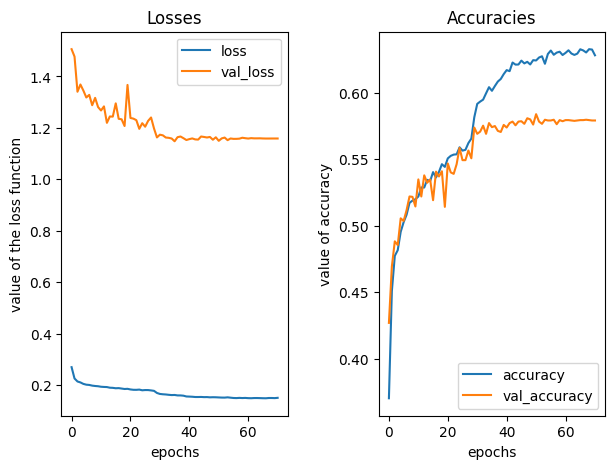

In [37]:
ftsuf = 'ft_2'
render_history(history, 'mobilenet12blocks_wdgenaug_'+ftsuf)

Example of at least 25 test data points from test dataset

In [38]:
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()

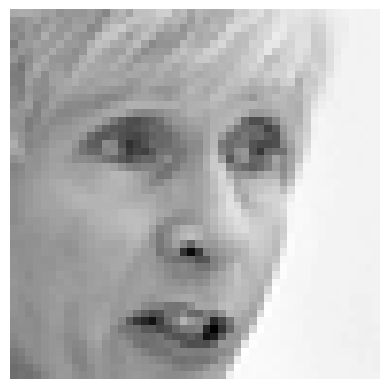

True Label: Angry
Predicted Label: Neutral
------------------------


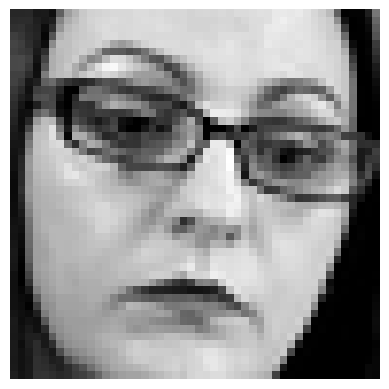

True Label: Sad
Predicted Label: Sad
------------------------


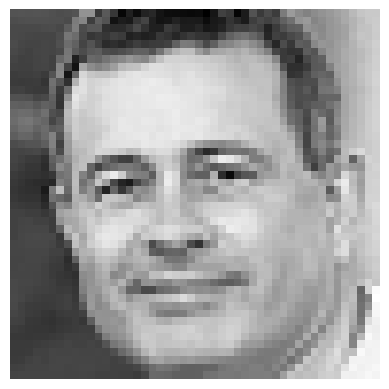

True Label: Happy
Predicted Label: Happy
------------------------


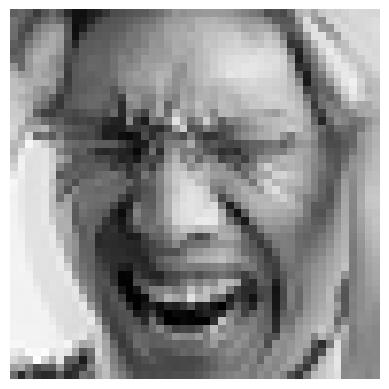

True Label: Fear
Predicted Label: Angry
------------------------


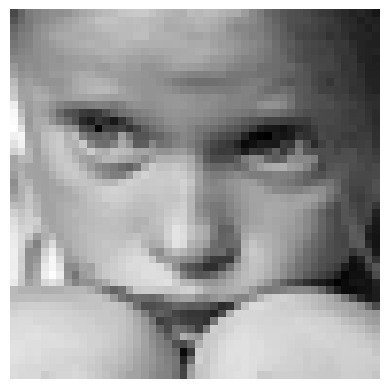

True Label: Sad
Predicted Label: Sad
------------------------


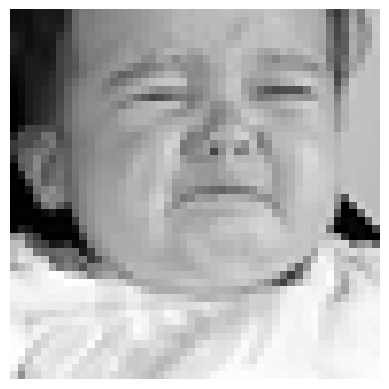

True Label: Sad
Predicted Label: Happy
------------------------


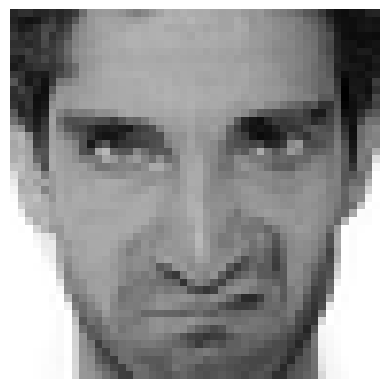

True Label: Angry
Predicted Label: Neutral
------------------------


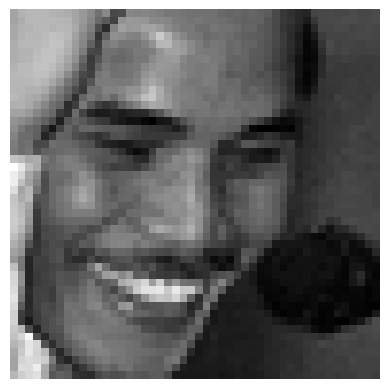

True Label: Happy
Predicted Label: Happy
------------------------


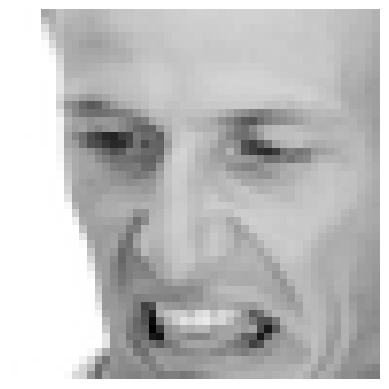

True Label: Disgust
Predicted Label: Angry
------------------------


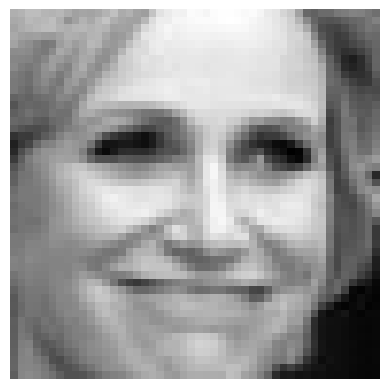

True Label: Happy
Predicted Label: Happy
------------------------


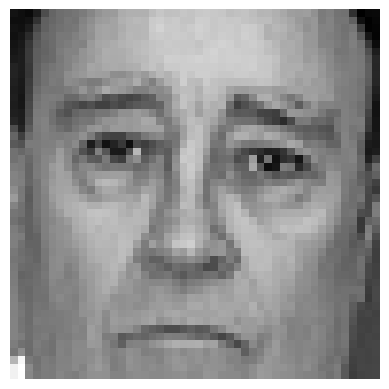

True Label: Sad
Predicted Label: Fear
------------------------


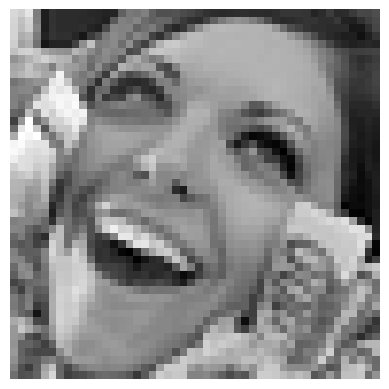

True Label: Happy
Predicted Label: Happy
------------------------


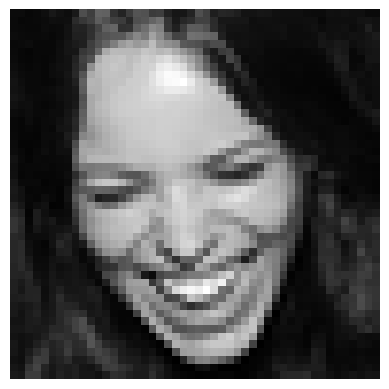

True Label: Happy
Predicted Label: Happy
------------------------


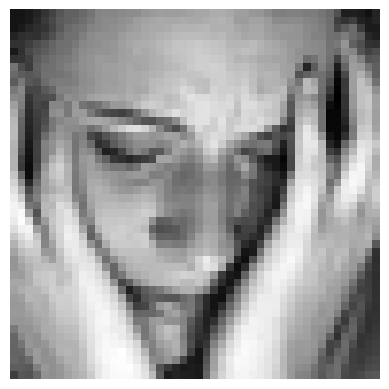

True Label: Sad
Predicted Label: Sad
------------------------


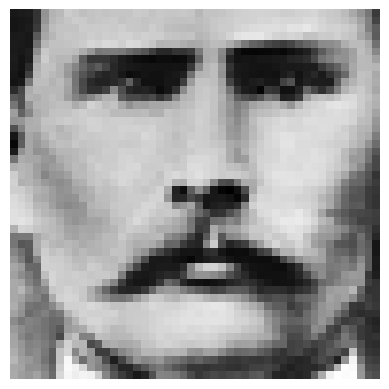

True Label: Fear
Predicted Label: Sad
------------------------


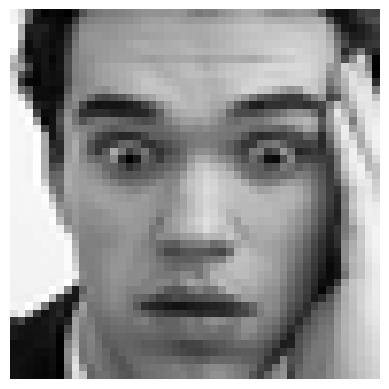

True Label: Surprise
Predicted Label: Surprise
------------------------


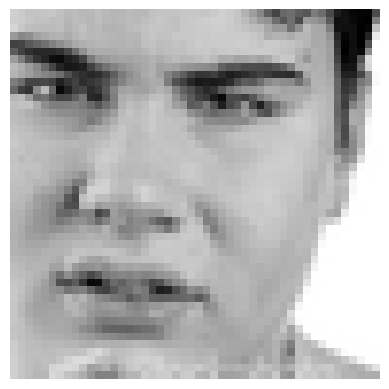

True Label: Fear
Predicted Label: Angry
------------------------


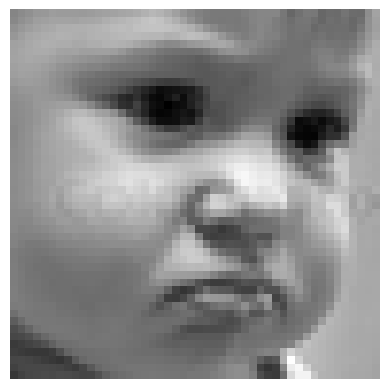

True Label: Sad
Predicted Label: Sad
------------------------


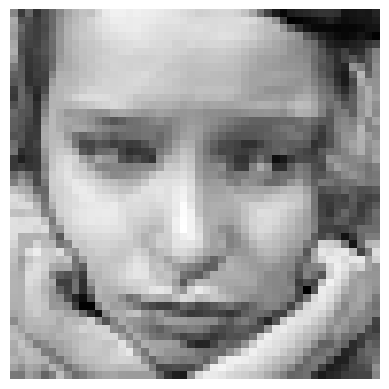

True Label: Sad
Predicted Label: Sad
------------------------


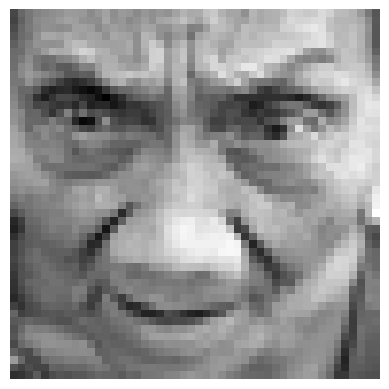

True Label: Surprise
Predicted Label: Angry
------------------------


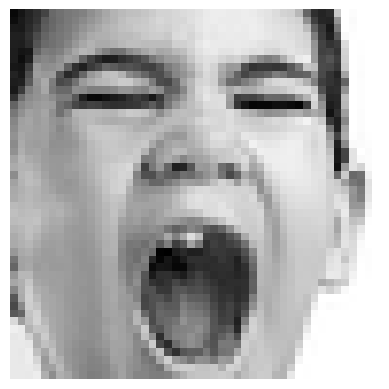

True Label: Angry
Predicted Label: Angry
------------------------


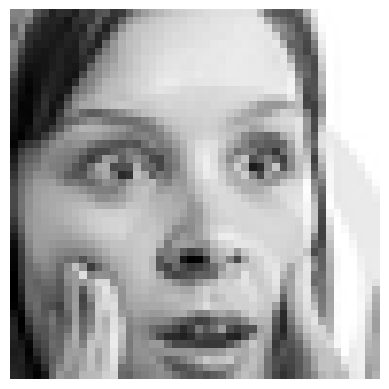

True Label: Surprise
Predicted Label: Surprise
------------------------


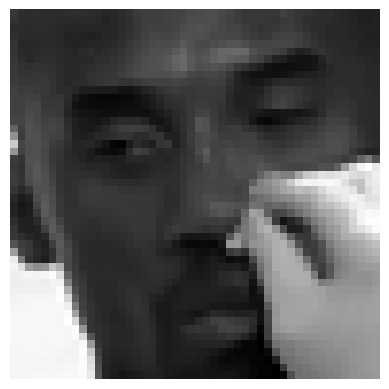

True Label: Angry
Predicted Label: Neutral
------------------------


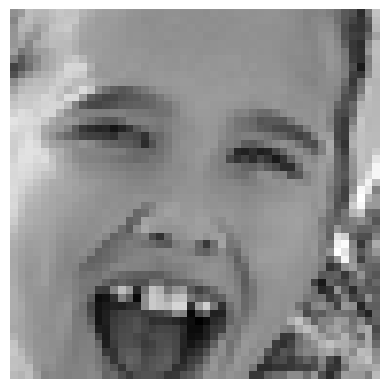

True Label: Happy
Predicted Label: Angry
------------------------


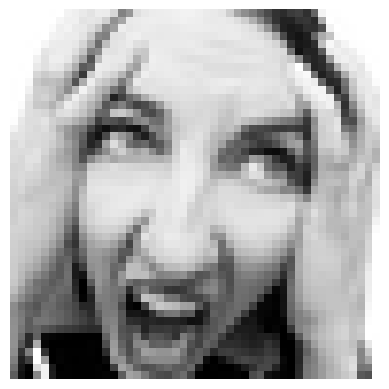

True Label: Angry
Predicted Label: Fear
------------------------


In [39]:
import numpy as np

# generate 25 random indices
random_indices = np.random.randint(0, len(test_images), size=25)

# loop through the indices and plot the image, true label, and predicted label
for index in random_indices:
    # plot the image
    plt.imshow(test_images[index].reshape(48, 48), cmap='gray')
    plt.axis('off')
    plt.show()
    
    # get the true label
    true_label = emotions[test_labels[index].argmax()]
    print('True Label:', true_label)
    
    # get the predicted label
    predicted_label = emotions[pred_test_labels[index].argmax()]
    print('Predicted Label:', predicted_label)
    
    print('------------------------')


In [46]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
experiment_log = []

# Example parameters to tune
num_layers_list = [1, 2, 3]
filter_sizes = [(3, 3), (5, 5), (7, 7)]
activation_functions = ['relu', 'sigmoid', 'tanh']

for num_layers in num_layers_list:
    for filter_size in filter_sizes:
        for activation_function in activation_functions:
           
            base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                     include_top=False,
                     weights='imagenet')

            base_model = Model(inputs = base_model.input,outputs = base_model.get_layer('block_12_project_BN').output, name = 'mobilenet_trunc')
            global_average_layer = GlobalAvgPool2D()
            prediction_layer = Dense(NUM_CLASSES, activation="softmax", name="pred")
            inputs_raw = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
            x = base_model(inputs_raw, training=False)

            x = global_average_layer(x)
            outputs = prediction_layer(x)
            model = Model(inputs=inputs_raw, outputs= outputs)
            
            for _ in range(num_layers):
                x = Dense(128, activation=activation_function)(x)
            predictions = Dense(7, activation='softmax')(x)  

            for layer in base_model.layers:
                layer.trainable = False

            model.compile(optimizer=Adam(lr=1e-3),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])
            datagen = ImageDataGenerator(rotation_range=15, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

            train_generator = datagen.flow(train_images_rgb, train_labels, batch_size=32) 

            # Train the model
            history = model.fit(
                train_generator, 
                steps_per_epoch=len(train_images_rgb)/ BATCH_SIZE, 
                epochs=10,
                validation_data=(test_images_rgb, test_labels), 
                validation_steps=len(test_images_rgb)
            )

            # Get the accuracy and loss for the current experiment
            train_loss, train_accuracy = model.evaluate(train_images_rgb, steps=len(train_images_rgb))
            test_loss, test_accuracy = model.evaluate(test_images_rgb, test_labels, steps=len(test_images_rgb))

            # Log the experiment results along with parameters
            experiment_log.append({
                'Number of layers': num_layers,
                'Filter Size Layer 1': filter_size,
                'Activation Function': activation_function,
                'Train Accuracy': train_accuracy,
                'Test Accuracy': test_accuracy,
                'Train Loss': train_loss,
                'Test Loss': test_loss
            })

            

Epoch 1/10
448/448 [==============================] - 27s 57ms/step - loss: 2.0383 - accuracy: 0.2454 - val_loss: 1.8151 - val_accuracy: 0.2976
Epoch 2/10
448/448 [==============================] - 27s 61ms/step - loss: 1.7724 - accuracy: 0.2954 - val_loss: 1.7196 - val_accuracy: 0.3374
Epoch 3/10
448/448 [==============================] - 27s 61ms/step - loss: 1.7138 - accuracy: 0.3196 - val_loss: 1.6581 - val_accuracy: 0.3597
Epoch 4/10
448/448 [==============================] - 27s 60ms/step - loss: 1.6710 - accuracy: 0.3396 - val_loss: 1.6687 - val_accuracy: 0.3683
Epoch 5/10
448/448 [==============================] - 27s 61ms/step - loss: 1.6489 - accuracy: 0.3505 - val_loss: 1.6333 - val_accuracy: 0.3781
Epoch 6/10
448/448 [==============================] - 27s 61ms/step - loss: 1.6287 - accuracy: 0.3608 - val_loss: 1.6133 - val_accuracy: 0.3798
Epoch 7/10
448/448 [==============================] - 28s 62ms/step - loss: 1.6214 - accuracy: 0.3631 - val_loss: 1.6113 - val_accuracy:

Epoch 1/10
448/448 [==============================] - 29s 62ms/step - loss: 2.0288 - accuracy: 0.2562 - val_loss: 1.8314 - val_accuracy: 0.2990
Epoch 2/10
448/448 [==============================] - 27s 60ms/step - loss: 1.7635 - accuracy: 0.3029 - val_loss: 1.7270 - val_accuracy: 0.3257
Epoch 3/10
448/448 [==============================] - 27s 60ms/step - loss: 1.7031 - accuracy: 0.3301 - val_loss: 1.6761 - val_accuracy: 0.3569
Epoch 4/10
448/448 [==============================] - 27s 60ms/step - loss: 1.6582 - accuracy: 0.3431 - val_loss: 1.6630 - val_accuracy: 0.3622
Epoch 5/10
448/448 [==============================] - 27s 60ms/step - loss: 1.6492 - accuracy: 0.3503 - val_loss: 1.6274 - val_accuracy: 0.3692
Epoch 6/10
448/448 [==============================] - 27s 60ms/step - loss: 1.6273 - accuracy: 0.3563 - val_loss: 1.6258 - val_accuracy: 0.3717
Epoch 7/10
448/448 [==============================] - 27s 61ms/step - loss: 1.6249 - accuracy: 0.3579 - val_loss: 1.6060 - val_accuracy:

Epoch 1/10
448/448 [==============================] - 29s 61ms/step - loss: 2.0657 - accuracy: 0.2382 - val_loss: 1.7861 - val_accuracy: 0.3070
Epoch 2/10
448/448 [==============================] - 26s 59ms/step - loss: 1.7397 - accuracy: 0.3087 - val_loss: 1.6939 - val_accuracy: 0.3402
Epoch 3/10
448/448 [==============================] - 27s 61ms/step - loss: 1.6767 - accuracy: 0.3364 - val_loss: 1.6581 - val_accuracy: 0.3558
Epoch 4/10
448/448 [==============================] - 27s 61ms/step - loss: 1.6576 - accuracy: 0.3431 - val_loss: 1.6275 - val_accuracy: 0.3722
Epoch 5/10
448/448 [==============================] - 27s 61ms/step - loss: 1.6274 - accuracy: 0.3650 - val_loss: 1.6476 - val_accuracy: 0.3681
Epoch 6/10
448/448 [==============================] - 27s 60ms/step - loss: 1.6313 - accuracy: 0.3583 - val_loss: 1.6200 - val_accuracy: 0.3787
Epoch 7/10
448/448 [==============================] - 27s 60ms/step - loss: 1.6246 - accuracy: 0.3545 - val_loss: 1.6212 - val_accuracy:

Epoch 1/10
448/448 [==============================] - 31s 66ms/step - loss: 2.0723 - accuracy: 0.2365 - val_loss: 1.8249 - val_accuracy: 0.2789
Epoch 2/10
448/448 [==============================] - 29s 64ms/step - loss: 1.7825 - accuracy: 0.2930 - val_loss: 1.7128 - val_accuracy: 0.3291
Epoch 3/10
448/448 [==============================] - 29s 64ms/step - loss: 1.7110 - accuracy: 0.3277 - val_loss: 1.6640 - val_accuracy: 0.3422
Epoch 4/10
448/448 [==============================] - 29s 66ms/step - loss: 1.6751 - accuracy: 0.3403 - val_loss: 1.6441 - val_accuracy: 0.3578
Epoch 5/10
448/448 [==============================] - 32s 70ms/step - loss: 1.6522 - accuracy: 0.3425 - val_loss: 1.6315 - val_accuracy: 0.3628
Epoch 6/10
448/448 [==============================] - 29s 65ms/step - loss: 1.6343 - accuracy: 0.3568 - val_loss: 1.6250 - val_accuracy: 0.3787
Epoch 7/10
448/448 [==============================] - 28s 62ms/step - loss: 1.6256 - accuracy: 0.3579 - val_loss: 1.5948 - val_accuracy:

Epoch 1/10
448/448 [==============================] - 34s 71ms/step - loss: 2.0767 - accuracy: 0.2350 - val_loss: 1.8549 - val_accuracy: 0.2875
Epoch 2/10
448/448 [==============================] - 28s 62ms/step - loss: 1.7670 - accuracy: 0.2992 - val_loss: 1.7197 - val_accuracy: 0.3349
Epoch 3/10
448/448 [==============================] - 27s 60ms/step - loss: 1.6887 - accuracy: 0.3294 - val_loss: 1.6644 - val_accuracy: 0.3516
Epoch 4/10
448/448 [==============================] - 28s 61ms/step - loss: 1.6724 - accuracy: 0.3385 - val_loss: 1.6421 - val_accuracy: 0.3636
Epoch 5/10
448/448 [==============================] - 29s 64ms/step - loss: 1.6447 - accuracy: 0.3482 - val_loss: 1.6212 - val_accuracy: 0.3750
Epoch 6/10
448/448 [==============================] - 29s 64ms/step - loss: 1.6340 - accuracy: 0.3552 - val_loss: 1.6298 - val_accuracy: 0.3672
Epoch 7/10
448/448 [==============================] - 28s 63ms/step - loss: 1.6181 - accuracy: 0.3632 - val_loss: 1.6373 - val_accuracy:

Epoch 1/10
448/448 [==============================] - 27s 57ms/step - loss: 2.0814 - accuracy: 0.2489 - val_loss: 1.7848 - val_accuracy: 0.3020
Epoch 2/10
448/448 [==============================] - 25s 56ms/step - loss: 1.7440 - accuracy: 0.3090 - val_loss: 1.7150 - val_accuracy: 0.3341
Epoch 3/10
448/448 [==============================] - 25s 55ms/step - loss: 1.6791 - accuracy: 0.3403 - val_loss: 1.6435 - val_accuracy: 0.3650
Epoch 4/10
448/448 [==============================] - 25s 55ms/step - loss: 1.6641 - accuracy: 0.3371 - val_loss: 1.6453 - val_accuracy: 0.3658
Epoch 5/10
448/448 [==============================] - 25s 55ms/step - loss: 1.6430 - accuracy: 0.3464 - val_loss: 1.6175 - val_accuracy: 0.3700
Epoch 6/10
448/448 [==============================] - 25s 55ms/step - loss: 1.6256 - accuracy: 0.3584 - val_loss: 1.6109 - val_accuracy: 0.3731
Epoch 7/10
448/448 [==============================] - 25s 56ms/step - loss: 1.6142 - accuracy: 0.3662 - val_loss: 1.6188 - val_accuracy:

Epoch 1/10
448/448 [==============================] - 27s 56ms/step - loss: 2.0438 - accuracy: 0.2434 - val_loss: 1.8406 - val_accuracy: 0.3043
Epoch 2/10
448/448 [==============================] - 24s 54ms/step - loss: 1.7690 - accuracy: 0.2984 - val_loss: 1.7229 - val_accuracy: 0.3282
Epoch 3/10
448/448 [==============================] - 24s 54ms/step - loss: 1.7037 - accuracy: 0.3242 - val_loss: 1.6934 - val_accuracy: 0.3558
Epoch 4/10
448/448 [==============================] - 24s 54ms/step - loss: 1.6682 - accuracy: 0.3456 - val_loss: 1.6522 - val_accuracy: 0.3692
Epoch 5/10
448/448 [==============================] - 24s 54ms/step - loss: 1.6363 - accuracy: 0.3515 - val_loss: 1.6442 - val_accuracy: 0.3664
Epoch 6/10
448/448 [==============================] - 24s 54ms/step - loss: 1.6353 - accuracy: 0.3554 - val_loss: 1.6496 - val_accuracy: 0.3759
Epoch 7/10
448/448 [==============================] - 25s 55ms/step - loss: 1.6136 - accuracy: 0.3648 - val_loss: 1.6195 - val_accuracy:

Epoch 1/10
448/448 [==============================] - 30s 62ms/step - loss: 2.0269 - accuracy: 0.2491 - val_loss: 1.8077 - val_accuracy: 0.3012
Epoch 2/10
448/448 [==============================] - 27s 60ms/step - loss: 1.7569 - accuracy: 0.3051 - val_loss: 1.7147 - val_accuracy: 0.3254
Epoch 3/10
448/448 [==============================] - 27s 60ms/step - loss: 1.6970 - accuracy: 0.3293 - val_loss: 1.6635 - val_accuracy: 0.3530
Epoch 4/10
448/448 [==============================] - 27s 61ms/step - loss: 1.6661 - accuracy: 0.3445 - val_loss: 1.6624 - val_accuracy: 0.3644
Epoch 5/10
448/448 [==============================] - 27s 60ms/step - loss: 1.6513 - accuracy: 0.3482 - val_loss: 1.6652 - val_accuracy: 0.3480
Epoch 6/10
448/448 [==============================] - 27s 60ms/step - loss: 1.6318 - accuracy: 0.3570 - val_loss: 1.6221 - val_accuracy: 0.3697
Epoch 7/10
448/448 [==============================] - 27s 60ms/step - loss: 1.6296 - accuracy: 0.3572 - val_loss: 1.6122 - val_accuracy:

Epoch 1/10
448/448 [==============================] - 29s 61ms/step - loss: 2.0838 - accuracy: 0.2305 - val_loss: 1.8691 - val_accuracy: 0.2912
Epoch 2/10
448/448 [==============================] - 27s 59ms/step - loss: 1.7859 - accuracy: 0.2953 - val_loss: 1.7270 - val_accuracy: 0.3310
Epoch 3/10
448/448 [==============================] - 27s 60ms/step - loss: 1.7053 - accuracy: 0.3202 - val_loss: 1.6857 - val_accuracy: 0.3530
Epoch 4/10
448/448 [==============================] - 27s 60ms/step - loss: 1.6720 - accuracy: 0.3362 - val_loss: 1.6553 - val_accuracy: 0.3753
Epoch 5/10
448/448 [==============================] - 27s 59ms/step - loss: 1.6500 - accuracy: 0.3477 - val_loss: 1.6849 - val_accuracy: 0.3522
Epoch 6/10
448/448 [==============================] - 26s 59ms/step - loss: 1.6269 - accuracy: 0.3619 - val_loss: 1.6134 - val_accuracy: 0.3865
Epoch 7/10
448/448 [==============================] - 26s 59ms/step - loss: 1.6330 - accuracy: 0.3554 - val_loss: 1.6099 - val_accuracy:

Epoch 1/10
448/448 [==============================] - 28s 58ms/step - loss: 2.0502 - accuracy: 0.2508 - val_loss: 1.8118 - val_accuracy: 0.2990
Epoch 2/10
448/448 [==============================] - 26s 58ms/step - loss: 1.7594 - accuracy: 0.3073 - val_loss: 1.7215 - val_accuracy: 0.3302
Epoch 3/10
448/448 [==============================] - 27s 60ms/step - loss: 1.7046 - accuracy: 0.3286 - val_loss: 1.6585 - val_accuracy: 0.3427
Epoch 4/10
448/448 [==============================] - 27s 61ms/step - loss: 1.6648 - accuracy: 0.3422 - val_loss: 1.6438 - val_accuracy: 0.3622
Epoch 5/10
448/448 [==============================] - 28s 62ms/step - loss: 1.6490 - accuracy: 0.3492 - val_loss: 1.6292 - val_accuracy: 0.3664
Epoch 6/10
448/448 [==============================] - 27s 61ms/step - loss: 1.6416 - accuracy: 0.3526 - val_loss: 1.6325 - val_accuracy: 0.3614
Epoch 7/10
448/448 [==============================] - 30s 68ms/step - loss: 1.6267 - accuracy: 0.3617 - val_loss: 1.6125 - val_accuracy:

Epoch 1/10
448/448 [==============================] - 27s 58ms/step - loss: 2.0016 - accuracy: 0.2494 - val_loss: 1.8215 - val_accuracy: 0.2797
Epoch 2/10
448/448 [==============================] - 25s 57ms/step - loss: 1.7749 - accuracy: 0.2964 - val_loss: 1.7345 - val_accuracy: 0.3266
Epoch 3/10
448/448 [==============================] - 25s 56ms/step - loss: 1.7061 - accuracy: 0.3268 - val_loss: 1.6836 - val_accuracy: 0.3327
Epoch 4/10
448/448 [==============================] - 25s 56ms/step - loss: 1.6717 - accuracy: 0.3381 - val_loss: 1.6715 - val_accuracy: 0.3594
Epoch 5/10
448/448 [==============================] - 25s 57ms/step - loss: 1.6548 - accuracy: 0.3477 - val_loss: 1.6292 - val_accuracy: 0.3667
Epoch 6/10
448/448 [==============================] - 26s 57ms/step - loss: 1.6369 - accuracy: 0.3529 - val_loss: 1.6175 - val_accuracy: 0.3764
Epoch 7/10
448/448 [==============================] - 26s 58ms/step - loss: 1.6357 - accuracy: 0.3579 - val_loss: 1.6056 - val_accuracy:

Epoch 1/10
448/448 [==============================] - 27s 57ms/step - loss: 2.0549 - accuracy: 0.2311 - val_loss: 1.8554 - val_accuracy: 0.2758
Epoch 2/10
448/448 [==============================] - 25s 56ms/step - loss: 1.7833 - accuracy: 0.2916 - val_loss: 1.7588 - val_accuracy: 0.3082
Epoch 3/10
448/448 [==============================] - 25s 55ms/step - loss: 1.7139 - accuracy: 0.3152 - val_loss: 1.7070 - val_accuracy: 0.3330
Epoch 4/10
448/448 [==============================] - 25s 56ms/step - loss: 1.6811 - accuracy: 0.3341 - val_loss: 1.6713 - val_accuracy: 0.3449
Epoch 5/10
448/448 [==============================] - 25s 56ms/step - loss: 1.6553 - accuracy: 0.3471 - val_loss: 1.6492 - val_accuracy: 0.3541
Epoch 6/10
448/448 [==============================] - 25s 56ms/step - loss: 1.6444 - accuracy: 0.3534 - val_loss: 1.6311 - val_accuracy: 0.3636
Epoch 7/10
448/448 [==============================] - 26s 57ms/step - loss: 1.6294 - accuracy: 0.3595 - val_loss: 1.6371 - val_accuracy:

Epoch 1/10
448/448 [==============================] - 28s 58ms/step - loss: 2.0277 - accuracy: 0.2579 - val_loss: 1.8642 - val_accuracy: 0.2817
Epoch 2/10
448/448 [==============================] - 25s 57ms/step - loss: 1.7558 - accuracy: 0.3058 - val_loss: 1.7408 - val_accuracy: 0.3249
Epoch 3/10
448/448 [==============================] - 25s 57ms/step - loss: 1.7033 - accuracy: 0.3260 - val_loss: 1.6902 - val_accuracy: 0.3396
Epoch 4/10
448/448 [==============================] - 25s 56ms/step - loss: 1.6682 - accuracy: 0.3424 - val_loss: 1.6559 - val_accuracy: 0.3430
Epoch 5/10
448/448 [==============================] - 25s 57ms/step - loss: 1.6447 - accuracy: 0.3498 - val_loss: 1.6384 - val_accuracy: 0.3583
Epoch 6/10
448/448 [==============================] - 26s 57ms/step - loss: 1.6309 - accuracy: 0.3609 - val_loss: 1.6390 - val_accuracy: 0.3608
Epoch 7/10
448/448 [==============================] - 26s 59ms/step - loss: 1.6178 - accuracy: 0.3636 - val_loss: 1.6235 - val_accuracy:

Epoch 1/10
448/448 [==============================] - 28s 58ms/step - loss: 2.0672 - accuracy: 0.2388 - val_loss: 1.8643 - val_accuracy: 0.2920
Epoch 2/10
448/448 [==============================] - 25s 56ms/step - loss: 1.7751 - accuracy: 0.2947 - val_loss: 1.7315 - val_accuracy: 0.3355
Epoch 3/10
448/448 [==============================] - 25s 56ms/step - loss: 1.7119 - accuracy: 0.3180 - val_loss: 1.6921 - val_accuracy: 0.3466
Epoch 4/10
448/448 [==============================] - 27s 60ms/step - loss: 1.6783 - accuracy: 0.3347 - val_loss: 1.6713 - val_accuracy: 0.3569
Epoch 5/10
448/448 [==============================] - 27s 60ms/step - loss: 1.6598 - accuracy: 0.3422 - val_loss: 1.6290 - val_accuracy: 0.3714
Epoch 6/10
448/448 [==============================] - 26s 58ms/step - loss: 1.6357 - accuracy: 0.3541 - val_loss: 1.6168 - val_accuracy: 0.3720
Epoch 7/10
448/448 [==============================] - 25s 56ms/step - loss: 1.6342 - accuracy: 0.3522 - val_loss: 1.6236 - val_accuracy:

Epoch 1/10
448/448 [==============================] - 30s 62ms/step - loss: 2.0892 - accuracy: 0.2487 - val_loss: 1.8203 - val_accuracy: 0.2928
Epoch 2/10
448/448 [==============================] - 28s 62ms/step - loss: 1.7598 - accuracy: 0.3096 - val_loss: 1.7344 - val_accuracy: 0.3310
Epoch 3/10
448/448 [==============================] - 27s 61ms/step - loss: 1.6976 - accuracy: 0.3266 - val_loss: 1.6965 - val_accuracy: 0.3441
Epoch 4/10
448/448 [==============================] - 27s 60ms/step - loss: 1.6648 - accuracy: 0.3395 - val_loss: 1.6742 - val_accuracy: 0.3525
Epoch 5/10
448/448 [==============================] - 25s 56ms/step - loss: 1.6470 - accuracy: 0.3527 - val_loss: 1.6528 - val_accuracy: 0.3639
Epoch 6/10
448/448 [==============================] - 25s 56ms/step - loss: 1.6341 - accuracy: 0.3616 - val_loss: 1.6299 - val_accuracy: 0.3795
Epoch 7/10
448/448 [==============================] - 25s 56ms/step - loss: 1.6288 - accuracy: 0.3609 - val_loss: 1.6136 - val_accuracy:

Epoch 1/10
448/448 [==============================] - 28s 59ms/step - loss: 2.1310 - accuracy: 0.2305 - val_loss: 1.8868 - val_accuracy: 0.2566
Epoch 2/10
448/448 [==============================] - 26s 57ms/step - loss: 1.8000 - accuracy: 0.2892 - val_loss: 1.7506 - val_accuracy: 0.3140
Epoch 3/10
448/448 [==============================] - 25s 57ms/step - loss: 1.7207 - accuracy: 0.3159 - val_loss: 1.7179 - val_accuracy: 0.3327
Epoch 4/10
448/448 [==============================] - 25s 56ms/step - loss: 1.6828 - accuracy: 0.3384 - val_loss: 1.6719 - val_accuracy: 0.3449
Epoch 5/10
448/448 [==============================] - 25s 55ms/step - loss: 1.6514 - accuracy: 0.3481 - val_loss: 1.6721 - val_accuracy: 0.3541
Epoch 6/10
448/448 [==============================] - 25s 55ms/step - loss: 1.6360 - accuracy: 0.3563 - val_loss: 1.6495 - val_accuracy: 0.3578
Epoch 7/10
448/448 [==============================] - 25s 55ms/step - loss: 1.6320 - accuracy: 0.3544 - val_loss: 1.6319 - val_accuracy:

Epoch 1/10
448/448 [==============================] - 28s 58ms/step - loss: 2.0722 - accuracy: 0.2519 - val_loss: 1.8169 - val_accuracy: 0.3006
Epoch 2/10
448/448 [==============================] - 25s 57ms/step - loss: 1.7573 - accuracy: 0.3100 - val_loss: 1.6924 - val_accuracy: 0.3391
Epoch 3/10
448/448 [==============================] - 25s 56ms/step - loss: 1.6768 - accuracy: 0.3354 - val_loss: 1.6550 - val_accuracy: 0.3519
Epoch 4/10
448/448 [==============================] - 25s 57ms/step - loss: 1.6414 - accuracy: 0.3553 - val_loss: 1.6149 - val_accuracy: 0.3706
Epoch 5/10
448/448 [==============================] - 25s 56ms/step - loss: 1.6429 - accuracy: 0.3533 - val_loss: 1.6075 - val_accuracy: 0.3814
Epoch 6/10
448/448 [==============================] - 25s 56ms/step - loss: 1.6298 - accuracy: 0.3568 - val_loss: 1.6263 - val_accuracy: 0.3728
Epoch 7/10
448/448 [==============================] - 25s 57ms/step - loss: 1.6217 - accuracy: 0.3572 - val_loss: 1.6141 - val_accuracy:

Epoch 1/10
448/448 [==============================] - 29s 60ms/step - loss: 2.0978 - accuracy: 0.2440 - val_loss: 1.8687 - val_accuracy: 0.2764
Epoch 2/10
448/448 [==============================] - 26s 58ms/step - loss: 1.7734 - accuracy: 0.3012 - val_loss: 1.7298 - val_accuracy: 0.3243
Epoch 3/10
448/448 [==============================] - 26s 58ms/step - loss: 1.7020 - accuracy: 0.3286 - val_loss: 1.7116 - val_accuracy: 0.3360
Epoch 4/10
448/448 [==============================] - 26s 58ms/step - loss: 1.6694 - accuracy: 0.3416 - val_loss: 1.6733 - val_accuracy: 0.3497
Epoch 5/10
448/448 [==============================] - 26s 57ms/step - loss: 1.6460 - accuracy: 0.3510 - val_loss: 1.6569 - val_accuracy: 0.3586
Epoch 6/10
448/448 [==============================] - 26s 58ms/step - loss: 1.6362 - accuracy: 0.3573 - val_loss: 1.6377 - val_accuracy: 0.3667
Epoch 7/10
448/448 [==============================] - 26s 58ms/step - loss: 1.6306 - accuracy: 0.3602 - val_loss: 1.6127 - val_accuracy:

Epoch 1/10
448/448 [==============================] - 29s 60ms/step - loss: 2.1615 - accuracy: 0.2375 - val_loss: 1.8708 - val_accuracy: 0.2873
Epoch 2/10
448/448 [==============================] - 28s 62ms/step - loss: 1.7757 - accuracy: 0.2977 - val_loss: 1.7430 - val_accuracy: 0.3218
Epoch 3/10
448/448 [==============================] - 28s 62ms/step - loss: 1.7071 - accuracy: 0.3233 - val_loss: 1.6936 - val_accuracy: 0.3399
Epoch 4/10
448/448 [==============================] - 27s 60ms/step - loss: 1.6788 - accuracy: 0.3348 - val_loss: 1.6578 - val_accuracy: 0.3533
Epoch 5/10
448/448 [==============================] - 29s 64ms/step - loss: 1.6554 - accuracy: 0.3500 - val_loss: 1.6322 - val_accuracy: 0.3614
Epoch 6/10
448/448 [==============================] - 29s 64ms/step - loss: 1.6357 - accuracy: 0.3584 - val_loss: 1.6351 - val_accuracy: 0.3603
Epoch 7/10
448/448 [==============================] - 28s 62ms/step - loss: 1.6304 - accuracy: 0.3599 - val_loss: 1.6177 - val_accuracy:

Epoch 1/10
448/448 [==============================] - 30s 63ms/step - loss: 2.1307 - accuracy: 0.2366 - val_loss: 1.8504 - val_accuracy: 0.2775
Epoch 2/10
448/448 [==============================] - 27s 61ms/step - loss: 1.7643 - accuracy: 0.2994 - val_loss: 1.7187 - val_accuracy: 0.3293
Epoch 3/10
448/448 [==============================] - 28s 62ms/step - loss: 1.7077 - accuracy: 0.3273 - val_loss: 1.6740 - val_accuracy: 0.3533
Epoch 4/10
448/448 [==============================] - 28s 62ms/step - loss: 1.6828 - accuracy: 0.3294 - val_loss: 1.6707 - val_accuracy: 0.3539
Epoch 5/10
448/448 [==============================] - 26s 59ms/step - loss: 1.6534 - accuracy: 0.3495 - val_loss: 1.6292 - val_accuracy: 0.3784
Epoch 6/10
448/448 [==============================] - 26s 58ms/step - loss: 1.6387 - accuracy: 0.3515 - val_loss: 1.6343 - val_accuracy: 0.3736
Epoch 7/10
448/448 [==============================] - 25s 57ms/step - loss: 1.6313 - accuracy: 0.3587 - val_loss: 1.6222 - val_accuracy:

Epoch 1/10
448/448 [==============================] - 27s 57ms/step - loss: 1.9973 - accuracy: 0.2529 - val_loss: 1.8084 - val_accuracy: 0.3123
Epoch 2/10
448/448 [==============================] - 25s 56ms/step - loss: 1.7317 - accuracy: 0.3144 - val_loss: 1.7162 - val_accuracy: 0.3293
Epoch 3/10
448/448 [==============================] - 25s 56ms/step - loss: 1.6892 - accuracy: 0.3391 - val_loss: 1.6685 - val_accuracy: 0.3469
Epoch 4/10
448/448 [==============================] - 25s 56ms/step - loss: 1.6600 - accuracy: 0.3419 - val_loss: 1.6382 - val_accuracy: 0.3605
Epoch 5/10
448/448 [==============================] - 25s 56ms/step - loss: 1.6451 - accuracy: 0.3540 - val_loss: 1.6315 - val_accuracy: 0.3636
Epoch 6/10
448/448 [==============================] - 26s 57ms/step - loss: 1.6329 - accuracy: 0.3547 - val_loss: 1.6428 - val_accuracy: 0.3642
Epoch 7/10
448/448 [==============================] - 25s 56ms/step - loss: 1.6247 - accuracy: 0.3640 - val_loss: 1.6134 - val_accuracy:

Epoch 1/10
448/448 [==============================] - 27s 57ms/step - loss: 1.9645 - accuracy: 0.2595 - val_loss: 1.8024 - val_accuracy: 0.3040
Epoch 2/10
448/448 [==============================] - 25s 57ms/step - loss: 1.7490 - accuracy: 0.3113 - val_loss: 1.6918 - val_accuracy: 0.3377
Epoch 3/10
448/448 [==============================] - 26s 57ms/step - loss: 1.6960 - accuracy: 0.3251 - val_loss: 1.6771 - val_accuracy: 0.3452
Epoch 4/10
448/448 [==============================] - 25s 56ms/step - loss: 1.6635 - accuracy: 0.3433 - val_loss: 1.6479 - val_accuracy: 0.3636
Epoch 5/10
448/448 [==============================] - 25s 55ms/step - loss: 1.6392 - accuracy: 0.3532 - val_loss: 1.6431 - val_accuracy: 0.3583
Epoch 6/10
448/448 [==============================] - 25s 56ms/step - loss: 1.6307 - accuracy: 0.3573 - val_loss: 1.6189 - val_accuracy: 0.3725
Epoch 7/10
448/448 [==============================] - 25s 55ms/step - loss: 1.6195 - accuracy: 0.3631 - val_loss: 1.5966 - val_accuracy:

Epoch 1/10
448/448 [==============================] - 28s 58ms/step - loss: 2.1658 - accuracy: 0.2339 - val_loss: 1.8369 - val_accuracy: 0.2984
Epoch 2/10
448/448 [==============================] - 25s 55ms/step - loss: 1.7739 - accuracy: 0.3005 - val_loss: 1.7205 - val_accuracy: 0.3371
Epoch 3/10
448/448 [==============================] - 25s 55ms/step - loss: 1.7078 - accuracy: 0.3237 - val_loss: 1.6773 - val_accuracy: 0.3500
Epoch 4/10
448/448 [==============================] - 25s 55ms/step - loss: 1.6652 - accuracy: 0.3501 - val_loss: 1.6717 - val_accuracy: 0.3597
Epoch 5/10
448/448 [==============================] - 25s 55ms/step - loss: 1.6465 - accuracy: 0.3528 - val_loss: 1.6527 - val_accuracy: 0.3617
Epoch 6/10
448/448 [==============================] - 28s 63ms/step - loss: 1.6436 - accuracy: 0.3470 - val_loss: 1.6425 - val_accuracy: 0.3631
Epoch 7/10
448/448 [==============================] - 26s 59ms/step - loss: 1.6343 - accuracy: 0.3529 - val_loss: 1.6121 - val_accuracy:

Epoch 1/10
448/448 [==============================] - 27s 56ms/step - loss: 2.0718 - accuracy: 0.2312 - val_loss: 1.8494 - val_accuracy: 0.2965
Epoch 2/10
448/448 [==============================] - 25s 55ms/step - loss: 1.7756 - accuracy: 0.2954 - val_loss: 1.7381 - val_accuracy: 0.3246
Epoch 3/10
448/448 [==============================] - 24s 55ms/step - loss: 1.7114 - accuracy: 0.3224 - val_loss: 1.6944 - val_accuracy: 0.3385
Epoch 4/10
448/448 [==============================] - 25s 57ms/step - loss: 1.6714 - accuracy: 0.3435 - val_loss: 1.6447 - val_accuracy: 0.3575
Epoch 5/10
448/448 [==============================] - 26s 57ms/step - loss: 1.6485 - accuracy: 0.3474 - val_loss: 1.6468 - val_accuracy: 0.3605
Epoch 6/10
448/448 [==============================] - 26s 57ms/step - loss: 1.6352 - accuracy: 0.3608 - val_loss: 1.6075 - val_accuracy: 0.3814
Epoch 7/10
448/448 [==============================] - 25s 56ms/step - loss: 1.6214 - accuracy: 0.3621 - val_loss: 1.6391 - val_accuracy:

Epoch 1/10
448/448 [==============================] - 28s 59ms/step - loss: 2.0680 - accuracy: 0.2428 - val_loss: 1.8124 - val_accuracy: 0.2814
Epoch 2/10
448/448 [==============================] - 26s 57ms/step - loss: 1.7557 - accuracy: 0.3028 - val_loss: 1.7353 - val_accuracy: 0.3227
Epoch 3/10
448/448 [==============================] - 27s 60ms/step - loss: 1.6963 - accuracy: 0.3246 - val_loss: 1.6664 - val_accuracy: 0.3360
Epoch 4/10
448/448 [==============================] - 27s 60ms/step - loss: 1.6724 - accuracy: 0.3385 - val_loss: 1.6677 - val_accuracy: 0.3519
Epoch 5/10
448/448 [==============================] - 26s 59ms/step - loss: 1.6506 - accuracy: 0.3459 - val_loss: 1.6244 - val_accuracy: 0.3636
Epoch 6/10
448/448 [==============================] - 26s 58ms/step - loss: 1.6376 - accuracy: 0.3521 - val_loss: 1.6162 - val_accuracy: 0.3781
Epoch 7/10
448/448 [==============================] - 27s 59ms/step - loss: 1.6223 - accuracy: 0.3628 - val_loss: 1.6155 - val_accuracy:

Epoch 1/10
448/448 [==============================] - 28s 60ms/step - loss: 2.0145 - accuracy: 0.2478 - val_loss: 1.8035 - val_accuracy: 0.3023
Epoch 2/10
448/448 [==============================] - 26s 58ms/step - loss: 1.7548 - accuracy: 0.3055 - val_loss: 1.7291 - val_accuracy: 0.3285
Epoch 3/10
448/448 [==============================] - 26s 58ms/step - loss: 1.6926 - accuracy: 0.3289 - val_loss: 1.6603 - val_accuracy: 0.3614
Epoch 4/10
448/448 [==============================] - 26s 57ms/step - loss: 1.6580 - accuracy: 0.3440 - val_loss: 1.6530 - val_accuracy: 0.3647
Epoch 5/10
448/448 [==============================] - 26s 58ms/step - loss: 1.6445 - accuracy: 0.3522 - val_loss: 1.6652 - val_accuracy: 0.3566
Epoch 6/10
448/448 [==============================] - 26s 58ms/step - loss: 1.6429 - accuracy: 0.3562 - val_loss: 1.6063 - val_accuracy: 0.3756
Epoch 7/10
448/448 [==============================] - 26s 58ms/step - loss: 1.6275 - accuracy: 0.3605 - val_loss: 1.6082 - val_accuracy:

Epoch 1/10
448/448 [==============================] - 28s 58ms/step - loss: 2.0905 - accuracy: 0.2474 - val_loss: 1.8530 - val_accuracy: 0.2984
Epoch 2/10
448/448 [==============================] - 26s 57ms/step - loss: 1.7659 - accuracy: 0.2968 - val_loss: 1.7379 - val_accuracy: 0.3285
Epoch 3/10
448/448 [==============================] - 26s 57ms/step - loss: 1.7075 - accuracy: 0.3220 - val_loss: 1.6870 - val_accuracy: 0.3472
Epoch 4/10
448/448 [==============================] - 26s 57ms/step - loss: 1.6711 - accuracy: 0.3369 - val_loss: 1.6473 - val_accuracy: 0.3558
Epoch 5/10
448/448 [==============================] - 25s 57ms/step - loss: 1.6557 - accuracy: 0.3476 - val_loss: 1.6479 - val_accuracy: 0.3697
Epoch 6/10
448/448 [==============================] - 26s 57ms/step - loss: 1.6310 - accuracy: 0.3573 - val_loss: 1.6521 - val_accuracy: 0.3639
Epoch 7/10
448/448 [==============================] - 25s 57ms/step - loss: 1.6288 - accuracy: 0.3507 - val_loss: 1.6366 - val_accuracy:

A table containing details of parameter testing and tuning.

In [47]:
experiment_log

[{'Number of layers': 1,
  'Filter Size Layer 1': (3, 3),
  'Activation Function': 'relu',
  'Train Accuracy': 0.0,
  'Test Accuracy': 0.37698522210121155,
  'Train Loss': 0.0,
  'Test Loss': 1.620858073234558},
 {'Number of layers': 1,
  'Filter Size Layer 1': (3, 3),
  'Activation Function': 'sigmoid',
  'Train Accuracy': 0.0,
  'Test Accuracy': 0.38395094871520996,
  'Train Loss': 0.0,
  'Test Loss': 1.6136915683746338},
 {'Number of layers': 1,
  'Filter Size Layer 1': (3, 3),
  'Activation Function': 'tanh',
  'Train Accuracy': 0.0,
  'Test Accuracy': 0.3906380534172058,
  'Train Loss': 0.0,
  'Test Loss': 1.5954517126083374},
 {'Number of layers': 1,
  'Filter Size Layer 1': (5, 5),
  'Activation Function': 'relu',
  'Train Accuracy': 0.0,
  'Test Accuracy': 0.3814432919025421,
  'Train Loss': 0.0,
  'Test Loss': 1.5846494436264038},
 {'Number of layers': 1,
  'Filter Size Layer 1': (5, 5),
  'Activation Function': 'sigmoid',
  'Train Accuracy': 0.0,
  'Test Accuracy': 0.39453887